In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 6.0)

# Cubic Spline Interpolator

In [4]:
from math import floor
import numpy as np
class Interpolator():
    
    num_terms = 27
    
    def __init__(self, n, xmin, xmax):
        
        assert ( n > self.num_terms)
        self.n      = n
        self.xmin   = xmin
        self.xmax   = xmax
        self.rdelta = (n-1) / (xmax - xmin)
        self.d      = np.zeros(n)
        self.coeffs = np.zeros(n+3)
        self.interp = np.vectorize(self.interpolate)
        
    def compute_interpolants( self, f ):
        
        n = self.n
        num_terms = self.num_terms
        a=np.sqrt((2.0+np.sqrt(3.0))/6.0)
        r_a = 1.0/a
        b=np.sqrt((2.0-np.sqrt(3.0))/6.0)
        b_a = b/a

        d1 = f[0]
        coeff_tmp = 1.0
        for i in range(num_terms):
           coeff_tmp *= (-b_a)
           d1 += coeff_tmp*f[n-2-i]

        self.d[0] = d1*r_a
        for i in range(1,n-1):
            self.d[i] = r_a*(f[i] - b*self.d[i-1])
        
        d1        = self.d[-2]
        coeff_tmp = 1.0
        for i in range(num_terms):
           coeff_tmp *= (-b_a)
           d1 += coeff_tmp*self.d[i]

        self.coeffs[n-1] = d1*r_a
    
        for i in range(n-2, 0, -1):
           self.coeffs[i] = r_a*(self.d[i-1] - b*self.coeffs[i+1])

        self.coeffs[0]  = self.coeffs[-4]
        self.coeffs[-1:-4:-1] = self.coeffs[3:0:-1]
        
    def interpolate( self, x ):
        
        rh      = self.rdelta
        t0      = (x-self.xmin)*rh
        cell    = floor(t0)
        dx      = t0 - cell
        cdx     = 1.0 - dx
        cim1    = self.coeffs[cell]
        ci      = self.coeffs[cell+1]
        cip1    = self.coeffs[cell+2]
        cip2    = self.coeffs[cell+3]
        t1      = 3.0*ci
        t3      = 3.0*cip1
        t2      = cdx*(cdx*(cdx*(cim1 - t1) + t1) + t1) + ci
        t4      =  dx*( dx*( dx*(cip2 - t3) + t3) + t3) + cip1
            
        return (t2 + t4) / 6.0
            


## Interpolation test

In [5]:
n =50
cs = Interpolator(n,0,1)
x = np.linspace(0,1,n)
y = np.sin(x*2*np.pi)
x_new = x.min() + np.random.random(n) * (x.max() - x.min())
x_new.sort()

In [6]:
%%timeit
cs.compute_interpolants(y)
y_new = cs.interp(x_new)

274 µs ± 11 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


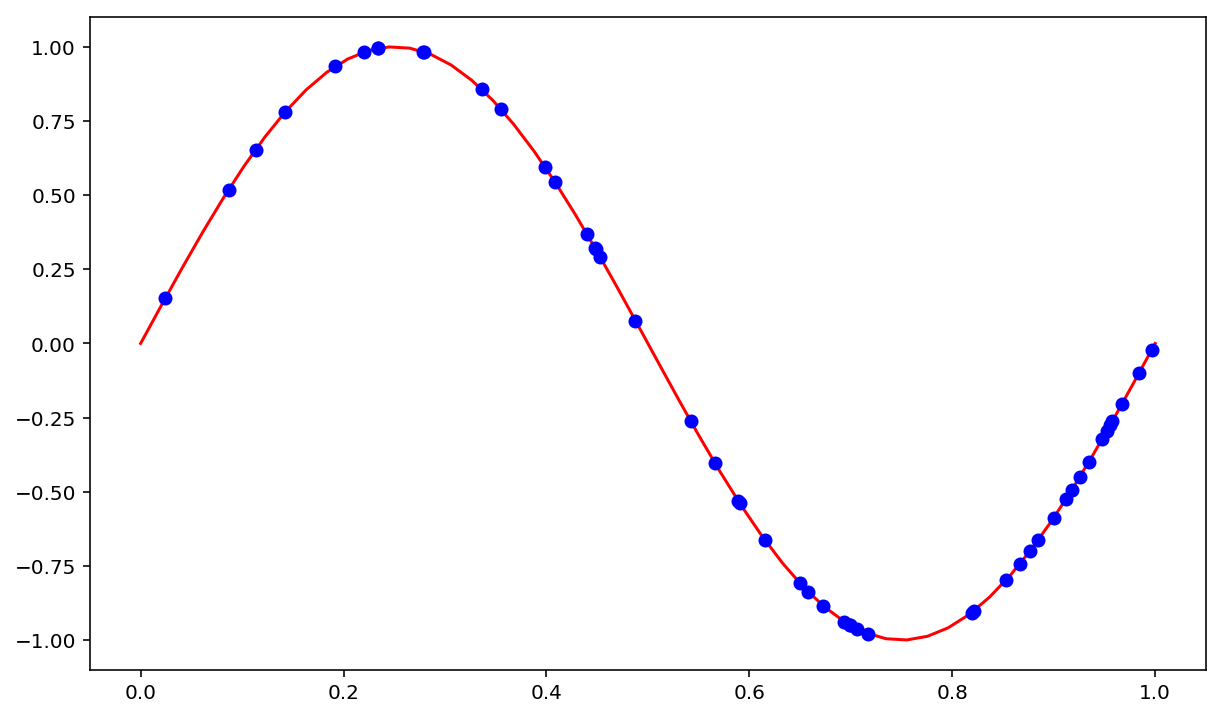

In [7]:
plt.plot(x, y, 'r-', x_new, cs.interp(x_new),'bo');

# Vlasov-Poisson equation
We consider the dimensionless Vlasov-Poisson equation for one species
with a neutralizing background.

$$ 
\frac{\partial f}{\partial t}+ v\cdot \nabla_x f + E(t,x) \cdot \nabla_v f = 0, \\
- \Delta \phi = 1 - \rho, E = - \nabla \phi \\
\rho(t,x)  =  \int f(t,x,v)dv.
$$





In [30]:
import progressbar
from scipy.fftpack import fft, ifft

class VlasovPoisson: # Backward Semi-Lagragian 
    
    
    def __init__(self, xmin, xmax, nx, vmin, vmax, nv):
        
        self.nx = nx
        self.x, self.dx = np.linspace(xmin, xmax, nx, retstep=True )
        self.nv = nv
        self.v, self.dv = np.linspace(vmin, vmax, nv, retstep=True)

        self.f = np.zeros((nx,nv))
            
        self.cs_x = Interpolator(nx, xmin, xmax)
        self.cs_v = Interpolator(nv, vmin, vmax)
        # Modes for Poisson equation
        self.modes = np.zeros(nx)
        k =  2* np.pi / (xmax - xmin)
        self.modes[:nx//2] = k * np.arange(nx//2)
        self.modes[nx//2:] = - k * np.arange(nx//2,0,-1)
        self.modes += self.modes == 0 # avoid division by zero 
        self.xmin = xmin
        self.xmax = xmax
        self.vmin = vmin
        self.vmax = vmax
        
        self.interp_x = np.vectorize(self.cs_x.interpolate)
        self.interp_v = np.vectorize(self.cs_v.interpolate)

    def advection_x(self, dt):
        for j in range(self.nv):
            self.cs_x.compute_interpolants(self.f[j,:])
            x_new = self.x - dt * self.v[j]
            x_new = self.xmin + np.mod( x_new - self.xmin, self.xmax-self.xmin)
            self.f[j,:] = self.interp_x(x_new)

    def advection_v(self, e, dt):
        for i in range(self.nx):
            self.cs_v.compute_interpolants(self.f[:,i])
            v_new = self.v - dt * e[i] 
            v_new = self.vmin + np.mod( v_new - self.vmin, self.vmax-self.vmin)
            self.f[:,i] = self.interp_v(v_new)
            
    def compute_rho(self):
        return  self.dv * np.sum(self.f, axis=0)
            
    def compute_e(self, rho):
        # compute Ex using that ik*Ex = rho
        rhok = fft(rho)/self.modes
        return np.real(ifft(-1j*rhok))
    
    def run(self, f, nstep, dt):
        nrj = []
        self.f = f
        self.advection_x(0.5*dt)
        bar = progressbar.ProgressBar()
        for istep in bar(range(nstep)):
            rho = self.compute_rho()
            e = self.compute_e(rho)
            self.advection_v(e, dt)
            self.advection_x(dt)
            nrj.append( 0.5*np.log(np.sum(e*e)*self.dx))
            
        return nrj

# Landau Damping

In [31]:

sim = VlasovPoisson(xmin = 0.0, xmax = 4*np.pi, nx = 128,
             vmin = -6., vmax = 6., nv = 128)

X, V = np.meshgrid(sim.x, sim.v)
eps = 0.05
kx  = 0.5 
f = (1.0+eps*np.cos(kx*X))/(2.0*np.pi)* np.exp(-0.5*V*V)

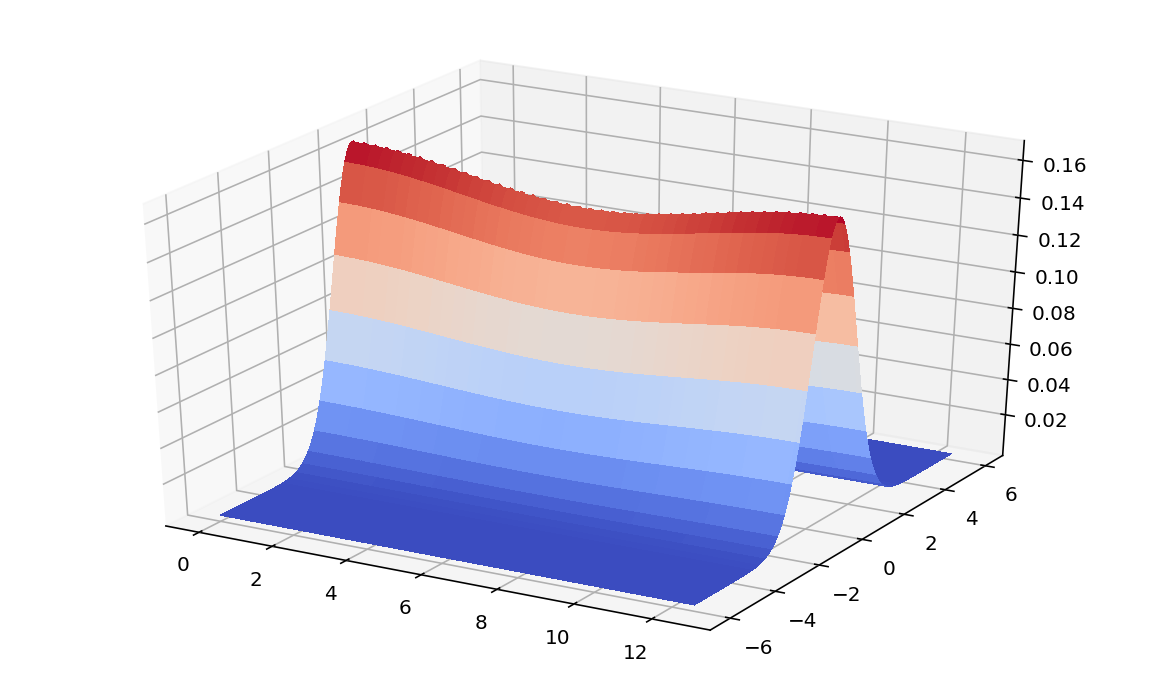

In [32]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, V, f, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


100% (500 of 500) |#######################| Elapsed Time: 0:01:18 Time: 0:01:18


CPU times: user 1min 17s, sys: 2.99 s, total: 1min 20s
Wall time: 1min 19s


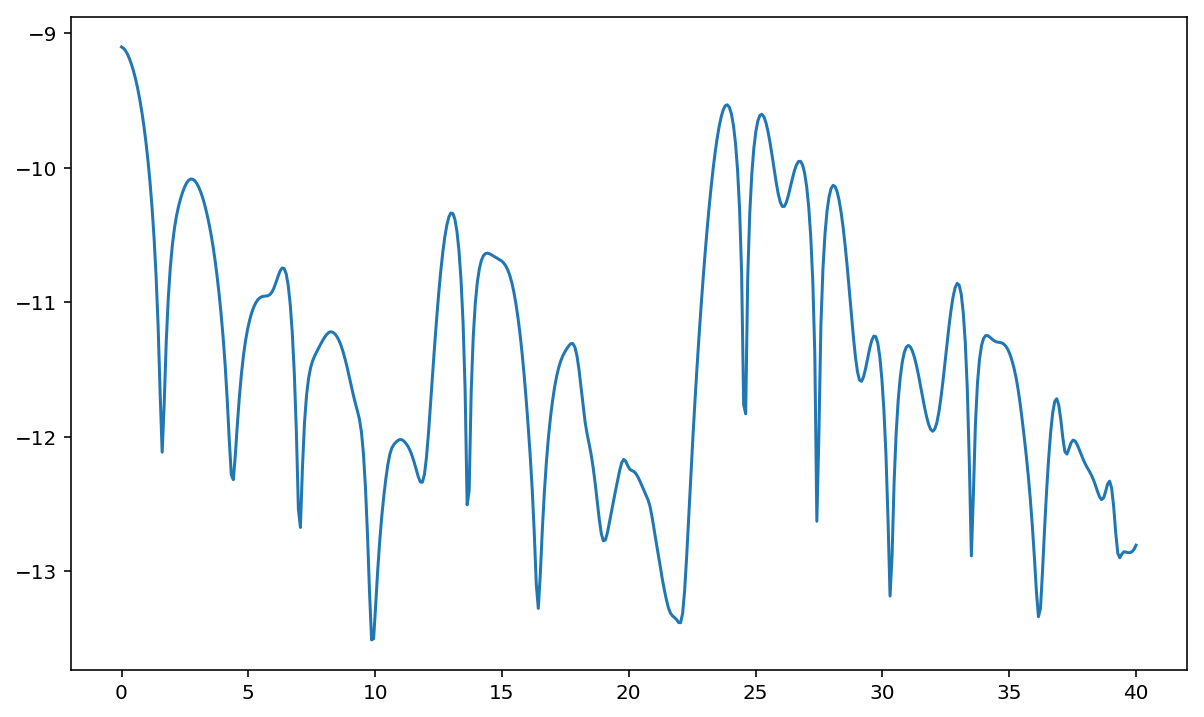

In [34]:
%%time
nstep = 500
t, dt = np.linspace(0.0, 50.0, nstep, retstep=True)

nrj = sim.run( f, nstep, dt)

plt.plot(t, nrj)

There's still a bug in my program ....